In [5]:
import math
import pickle

import librosa.feature
import numpy as np
import tensorflow as tf


In [6]:
def get_feature(
        y,
        sr,
        num_mfcc=13,
        n_fft=2048,
        hop_length=512,
        num_segment=5
):
    samples_per_track = sr * 30
    samples_per_segment = int(samples_per_track / num_segment)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for n in range(num_segment):
        start = samples_per_segment * n
        finish = start + samples_per_segment
        mfcc = librosa.feature.mfcc(
            y=y[start:finish],
            sr=sr,
            n_mfcc=num_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        )
        mfcc = mfcc.T

        if len(mfcc) != num_mfcc_vectors_per_segment:
            return None

        return mfcc.tolist()

In [7]:
def make_features():
    with open('../pickles/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    xs = []
    ys = []
    for label, y, sr, filename in data:
        feature = get_feature(y, sr)
        if not feature:
            continue
        xs.append(feature)
        ys.append(label)
    xs = np.array(xs)
    ys = tf.one_hot(np.array(ys), 10)
    print(xs.shape)
    print(ys.shape)

    with open('features.pkl', 'wb') as f:
        pickle.dump((xs, ys), f)


In [8]:
make_features()


(999, 259, 13)
(999, 10)


In [9]:
def make_training_data(features_pickle):
    with open(features_pickle, 'rb') as f:
        xs, ys = pickle.load(f)
    total = len(xs)
    permutations = np.random.permutation(total)
    features = np.array(xs)[permutations]
    labels = np.array(ys)[permutations]
    features_train = features[0:700]
    labels_train = labels[0:700]
    features_validate = features[700:850]
    labels_validate = labels[700:850]
    features_test = features[850:total]
    labels_test = labels[850:total]
    data_set = (
        (labels_train, features_train),
        (labels_validate, features_validate),
        (labels_test, features_test)
    )
    with open('data_set.pkl', 'wb') as f:
        pickle.dump(data_set, f)


In [10]:
 make_training_data('./features.pkl')


In [11]:
def load_data():
    with open('data_set.pkl', 'rb') as f:
        data_set = pickle.load(f)

    return data_set


In [12]:
data_set = load_data()

In [19]:
from keras import Input, Model

from keras.layers import LSTM, Dense


def build_model(input_shape):
    inputs = Input(shape=(259, 13), name="feature")
    x = LSTM(64, return_sequences=True, name="lstm_1")(inputs)
    x = LSTM(64, name="lstm_2")(x)
    x = Dense(64, activation="relu", name="dense_1")(x)
    outputs = Dense(10, activation="softmax", name="predictions")(x)

    return Model(inputs=inputs, outputs=outputs)


In [20]:
model = build_model((259, 13))


2023-05-28 17:04:35.173004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 17:04:35.174449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 17:04:35.175416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [22]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

In [23]:
model.compile(optimizer=optimiser,
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [24]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (InputLayer)        [(None, 259, 13)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 259, 64)           19968     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [25]:
def train(model, data_set):
    return model.fit(
        x=data_set[0][1].tolist(),
        y=data_set[0][0].tolist(),
        verbose=1,
        validation_data=(data_set[1][1].tolist(), data_set[1][0].tolist()),
        batch_size=32,
        epochs=50
    )

In [26]:
history = train(model, data_set)


Epoch 1/50


2023-05-28 17:08:50.509062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 17:08:50.510589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 17:08:50.511741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - ETA: 0s - loss: 2.2075 - accuracy: 0.2029

2023-05-28 17:08:57.633955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 17:08:57.635501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 17:08:57.636350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 8s 218ms/step - loss: 2.2075 - accuracy: 0.2029 - val_loss: 2.1062 - val_accuracy: 0.2600
Epoch 2/50
22/22 [==============================] - 3s 118ms/step - loss: 1.9415 - accuracy: 0.3557 - val_loss: 1.8905 - val_accuracy: 0.3267
Epoch 3/50
22/22 [==============================] - 3s 117ms/step - loss: 1.7075 - accuracy: 0.3971 - val_loss: 1.7045 - val_accuracy: 0.3867
Epoch 4/50
22/22 [==============================] - 3s 118ms/step - loss: 1.5329 - accuracy: 0.4571 - val_loss: 1.5894 - val_accuracy: 0.4133
Epoch 5/50
22/22 [==============================] - 3s 116ms/step - loss: 1.3834 - accuracy: 0.5129 - val_loss: 1.6750 - val_accuracy: 0.4333
Epoch 6/50
22/22 [==============================] - 3s 116ms/step - loss: 1.3514 - accuracy: 0.5257 - val_loss: 1.6467 - val_accuracy: 0.4600
Epoch 7/50
22/22 [==============================] - 3s 116ms/step - loss: 1.2530 - accuracy: 0.5600 - val_loss: 1.5969 - val_accuracy: 0.4533
Epoch 8/50
22/22 

In [27]:
def evaluate_model(model, data_set):
    return model.evaluate(x=data_set[2][1].tolist(), y=data_set[2][0].tolist(), verbose=0, return_dict=True)


In [28]:
evaluation = evaluate_model(model, data_set)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")


loss: 2.5181
accuracy: 0.4497


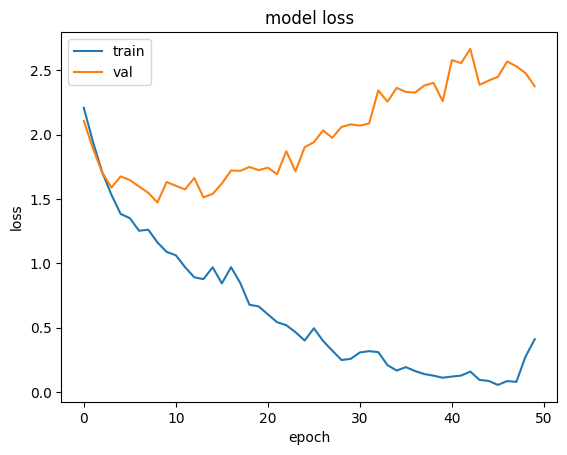

In [34]:
from utilities.training_plots import plot_loss

plot_loss(history)
